# 基于TensorFlow CNN数字识别

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import tensorflow as tf

from keras.utils import np_utils
from sklearn.cross_validation import train_test_split

LEARNING_RATE = 1e-4# 设置学习速率
TRAINING_ITERATIONS = 2500# 迭代次数

DROPOUT = 0.5# 防止过拟合
BATCH_SIZE = 50# 批下降数据量
VALIDATION_SIZE = 2000# 验证大小
IMAGE_TO_DISPLAY = 10

Using Theano backend.


导入数据，并且数据预处理

In [2]:
data = pd.read_csv('/Users/hehongwei/datas/数字识别器/train.csv')
print data.shape
data.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
images = data.iloc[:, 1:].values
images = images.astype('float')
images = images / 255
images.shape

(42000, 784)

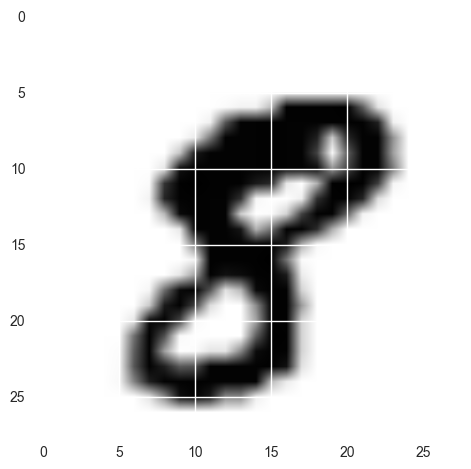

In [4]:
plt.imshow(images[10].reshape(28, 28))

In [5]:
labels_flat = data['label'].values
print labels_flat.shape
print type(labels_flat)

(42000,)
<type 'numpy.ndarray'>


In [6]:
labels = np_utils.to_categorical(labels_flat)
print labels.shape
print labels[0]

(42000, 10)
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


In [7]:
train_images, validation_images, train_labels, validation_labels = train_test_split(images, labels)
print train_images.shape
print train_labels.shape
print validation_images.shape
print validation_labels.shape

(31500, 784)
(31500, 10)
(10500, 784)
(10500, 10)


### TensorFlow 深度学习

定义权重和偏差

In [8]:
def weight_varible(shape):
    '''参数均值为0，方差为0.1满足正态分布的初始矩阵'''
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)
def biase_varible(shape):
    '''定义偏差为常数值'''
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

定义卷积核池化

In [9]:
def conv2d(x, W):
    ''' 
    定义卷积层，步长为strides=[1, 1, 1, 1],左右2个1是默认值,这样的参数不会压缩图片尺寸
    x是图像参数，W是这个卷积层的权重
    '''
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
def max_poo_2x2(x):
    '''
    2*2的池化，表示每2*2个像素点，取最大的那个值表示，步长为2
    这样图像尺寸压缩为0.5*0.5
    '''
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

开始添加神经层

In [10]:
with tf.name_scope('inputs'):
    # 定义输入值空间
    xs = tf.placeholder(tf.float32, [None, 784], name='x_input') # 训练数据类型为None*784
    ys = tf.placeholder(tf.float32, [None, 10], name='y_input') # 标签值为None*10
    keep_prob = tf.placeholder(tf.float32, name='drop_prob') # 定义一个dropout值

In [11]:
# 处理xs
x_image = tf.reshape(xs, [-1, 28, 28, 1]) # 将图片预处理为TensorFlow能够计算的输入类型数据（样本数*长*宽*颜色通道）

定义第一层卷积核
- 定义W和b
- 进行卷积计算
- 池化

In [12]:
with tf.name_scope('conv1'):
    # 32个5*5*1的经过初始化的卷积核
    with tf.name_scope('weights'):
        W_conv1 = weight_varible([5, 5, 1, 32])
        tf.summary.histogram('conv1_weights', W_conv1)
    with tf.name_scope('biases'):
        b_conv1 = biase_varible([32])
        tf.summary.histogram('conv1_biases', b_conv1)
    # 通过卷积后再进行非线性relu处理
    with tf.name_scope('h_conv1'):
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) #由于用得是SAME，所以尺寸为-1*28*28*32
        tf.summary.histogram('conv1_h', h_conv1)
    # 池化
    with tf.name_scope('h_pool1'):
        h_pool1 = max_poo_2x2(h_conv1) # 经过池化之后，尺寸降为-1*14*14*32
        tf.summary.histogram('conv1_h_pool1', h_pool1)
    # 添加dropout防止过拟合
    # h_pool1_drop = tf.nn.dropout(h_pool1, keep_prob=keep_prob)
    # h_pool1_drop = h_pool1
    # 计算得到的h_pool1_drop就是下一层的输入值

计算测试一下其第一层的某些 输出值

In [13]:
# sess = tf.Session()
# init = tf.global_variables_initializer()
# sess.run(init)
# cs = sess.run(h_pool1_drop, feed_dict={xs: train_images, ys: train_labels, keep_prob: 0.5})

In [14]:
# cs.shape

定义第二层卷积核，本层输入图像x为上一层的h_pool1_drop,尺寸为-1*14*14*32，这一次，将图像进一步变小，变厚

In [15]:
with tf.name_scope('conv2'):
    with tf.name_scope('weights'):
        # 定义64个5*5*32的经过初始化的卷积核
        W_conv2 = weight_varible([5, 5, 32, 64])
        tf.summary.histogram('conv2_weights', W_conv2)
    with tf.name_scope('biases'):
        b_conv2 = biase_varible([64])
        tf.summary.histogram('conv2_biases', b_conv2)
    with tf.name_scope('h_conv2'):
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # 由于用的是SAME，这里图像尺寸为-1*14*14*64
        tf.summary.histogram('conv2_h', h_conv2)
    with tf.name_scope('h_pool2'):
        h_pool2 = max_poo_2x2(h_conv2) # 池化之后图片变为-1*7*7*64
        tf.summary.histogram('conv2_h_pool2', h_pool2)
    # h_pool2_drop = tf.nn.dropout(h_pool2, keep_prob=keep_prob)
    # h_pool2_drop = h_pool2

在测试一下

In [16]:
# sess = tf.Session()
# init = tf.global_variables_initializer()
# sess.run(init)
# cs2 = sess.run(h_pool2_drop, feed_dict={xs: train_images, ys: train_labels, keep_prob: 0.5})

In [17]:
# cs2.shape

下面添加全连接层
- 将卷积层的输出展平
- 添加全连接层的隐藏层
- 输出层

In [18]:
with tf.name_scope('flatten'):
    h_pool2_drop_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    tf.summary.histogram('flatten', h_pool2_drop_flat)

In [19]:
with tf.name_scope('full_layer1'):
    # 添加一个隐藏层，隐藏层神经元数量为1024个
    W_fc1 = weight_varible([7*7*64, 1024])
    b_fc1 = biase_varible([1024])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_drop_flat, W_fc1) + b_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [20]:
# 添加第二个隐藏层，64个神经元
# W_fc2 = weight_varible([1024, 64])
# b_fc2 = biase_varible([64])
# h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
# h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

In [21]:
with tf.name_scope('full_layer2'):
    # 添加输出层
    W_fc3 = weight_varible([1024, 10])
    b_fc3 = biase_varible([10])
    prediction = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc3) + b_fc3) # 使用softmax分类

神经层全部搭建完毕之后，需要代价函数，使用交叉熵损失函数

In [22]:
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction), reduction_indices=[1]))
    tf.summary.scalar('loss', cross_entropy)

用tf.train.AdamOptimizer()作为我们的优化器进行优化，使我们的cross_entropy最小

In [23]:
with tf.name_scope('train_step'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [24]:
sess = tf.Session()
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('logs/train', sess.graph)
test_writer = tf.summary.FileWriter('logs/test', sess.graph)
init = tf.global_variables_initializer()
sess.run(init)

In [25]:
# 计算精确度
def compute_accuracy(v_xs, v_ys):
    global prediction
    y_pre = sess.run(prediction, feed_dict={xs: v_xs, ys: v_ys, keep_prob: 0.5})
    correct_prediction = tf.equal(tf.argmax(y_pre, 1), tf.argmax(v_ys, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    result = sess.run(accuracy, feed_dict={xs: v_xs, ys: v_ys, keep_prob: 1})
    return result

In [ ]:
for i in range(1000):
    j = i * 50 % 31500
    batch_xs = train_images[j: j+50]
    batch_ys = train_labels[j: j+50]
    sess.run(train_step, feed_dict={xs: batch_xs, ys: batch_ys, keep_prob: 0.5})
    if i % 50 == 0:
        print compute_accuracy(validation_images, validation_labels)
        train_result = sess.run(merged, feed_dict={xs: batch_xs, ys: batch_ys, keep_prob: 1})
        test_result = sess.run(merged, feed_dict={xs: batch_xs, ys: batch_ys, keep_prob: 1})
        train_writer.add_summary(train_result, i)
        test_writer.add_summary(test_result, i)

0.101524
0.43981
0.663429


<img  src="graph.png"/>

<img  src="loss.png"/>